# Copyright Netherlands eScience Center <br>
** Function     : Compare oceanic meridional energy transport (ORAS4,GLORYS2V3,SODA3,NEMO)** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to compare the oceanic meridional energy transport
                  calculated from different oceanic reanalysis datasets. In this,
                  case, this includes GLORYS2V3 from Mercator Ocean, ORAS4 from ECMWF,
                  and SODA3 from University of Maryland & TAMU.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Meridional Energy Transport               E         [Tera-Watt]<br>
                  Meridional Overturning Circulation        Psi       [Sv]<br>
Caveat!!        : Resolution

                  GLORYS2V3   1993 - 2014
                  ORAS4       1958 - 2014
                  SODA3       1980 - 2015
                  NEMO ORCA   1979 - 2012
                  
                  MOM5 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: MOM5 Arakawa-B grid
                  Dimension:
                  Latitude      1070
                  Longitude     1440
                  Depth         50
                  
                  ORCA1 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      362
                  Longitude     292
                  Depth         42
                  
                  ORCA025 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      1021
                  Longitude     1440
                  Depth         75

                  ORCA083 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      1565
                  Longitude     4322
                  Depth         75

                  The mask might have filled value of 1E+20 (in order to maintain
                  the size of the netCDF file and make full use of the storage). When
                  take the mean of intergral, this could result in abnormal large results.
                  With an aim to avoid this problem, it is important to re-set the filled
                  value to be 0 and then take the array with filled value during calculation.
                  (use "masked_array.filled()")

In [1]:
import numpy as np
import seaborn as sns
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas
from scipy import stats


In [2]:
# specify data path
# OMET
#datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/postprocessing'
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'
datapath_NEMO = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORCA012_BenMoat/postprocessing'
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures'
# index of latitude for insteret

# 20 N (no cut)
lat_ORAS4_20 = 181
lat_GLORYS2V3_20 = 579
lat_SODA3_20 = 569
lat_NEMO_20 = 245

# 30 N (no cut)
lat_ORAS4_30 = 192
lat_GLORYS2V3_30 = 623
lat_SODA3_30 = 613
lat_NEMO_30 = 377

# 40 N (no cut)
lat_ORAS4_40 = 204
lat_GLORYS2V3_40 = 672
lat_SODA3_40 = 662
lat_NEMO_40 = 522

# 50 N (no cut)
lat_ORAS4_50 = 218
lat_GLORYS2V3_50 = 726
lat_SODA3_50 = 719
lat_NEMO_50 = 685

# 60 N (no cut)
lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
lat_NEMO_60 = 871

# 70 N (no cut)
lat_ORAS4_70 = 250
lat_GLORYS2V3_70 = 857
lat_SODA3_70 = 880
lat_NEMO_70 = 1078

# 80 N (no cut)
lat_ORAS4_80 = 269
lat_GLORYS2V3_80 = 932
lat_SODA3_80 = 974
lat_NEMO_80 = 1303

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [20,30,40,50,60,70,80]
lat_interest['ORAS4'] = [lat_ORAS4_20,lat_ORAS4_30,lat_ORAS4_40,lat_ORAS4_50,lat_ORAS4_60,lat_ORAS4_70,lat_ORAS4_80]
lat_interest['GLORYS2V3'] = [lat_GLORYS2V3_20,lat_GLORYS2V3_30,lat_GLORYS2V3_40,lat_GLORYS2V3_50,lat_GLORYS2V3_60,lat_GLORYS2V3_70,lat_GLORYS2V3_80]
lat_interest['SODA3'] = [lat_SODA3_20,lat_SODA3_30,lat_SODA3_40,lat_SODA3_50,lat_SODA3_60,lat_SODA3_70,lat_SODA3_80]
lat_interest['NEMO'] = [lat_NEMO_20,lat_NEMO_30,lat_NEMO_40,lat_NEMO_50,lat_NEMO_60,lat_NEMO_70,lat_NEMO_80]


In [3]:
# ORCA1_z42 grid infor (Madec and Imbard 1996)
ji_1 = 362
jj_1 = 292
level_1 = 42

# ORCA025_z75 grid infor (Madec and Imbard 1996)
ji_025 = 1440
jj_025 = 1021
level_025 = 75

# MOM5_z50
ji_5 = 1440
jj_5 = 1070
level_5 = 50

# ORCA0083_z75
ji_083 = 4322
jj_083 = 1565
level_083 = 75

# zonal integral
dataset_GLORYS2V3 = Dataset(datapath_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_E_zonal_int.nc')
#dataset_ORAS4 = Dataset(datapath_ORAS4 + os.sep + 'oras4_model_monthly_orca1_E_zonal_int.nc')
dataset_SODA3 = Dataset(datapath_SODA3 + os.sep + 'OMET_SODA3_model_5daily_1980_2015_E_zonal_int.nc')
dataset_NEMO = Dataset(datapath_NEMO + os.sep + 'OMET_NEMO_ORCA0083_daily_1979_2012_E_zonal_int.nc')
dataset_ORAS4 = Dataset(os.path.join(datapath_ORAS4,
                                     'oras_model_monthly_1958_2017_omet.nc'))
# extract Oceanic meridional energy transport
# dimension (year,month,latitude)
# selected latitude (60N)
OMET_GLORYS2V3 = dataset_GLORYS2V3.variables['E'][:]/1000 # from Tera Watt to Peta Watt # start from 1993
OMET_ORAS4 = dataset_ORAS4.variables['E_int'][21:-1,:,:]/1000 # from Tera Watt to Peta Watt # start from 1979
OMET_SODA3 = dataset_SODA3.variables['E'][:]/1000 # from Tera Watt to Peta Watt # start from 1979
OMET_NEMO = dataset_NEMO.variables['E'][:]/1000 # from Tera Watt to Peta Watt # start from 1979 - 2012
# correction for a missing value at December 2005
OMET_NEMO[26,11,:] = (OMET_NEMO[26,10,:] + OMET_NEMO[27,0,:])/2

#year
year_ORAS4 = dataset_ORAS4.variables['year'][21:-1]         # from 1979 to 2014
year_GLORYS2V3 = dataset_GLORYS2V3.variables['year'][:]   # from 1993 to 2014
year_SODA3 = dataset_SODA3.variables['year'][:]           # from 1980 to 2014
year_NEMO = dataset_NEMO.variables['year'][:]             # from 1979 to 2012
# latitude
latitude_GLORYS2V3 = dataset_GLORYS2V3.variables['latitude_aux'][:]
latitude_ORAS4 = dataset_ORAS4.variables['latitude_aux'][:]
latitude_SODA3 = dataset_SODA3.variables['latitude_aux'][:]
latitude_NEMO = dataset_NEMO.variables['latitude_aux'][:]

In [4]:
# remove the seasonal cycling of OMET at 60N
month_ind = np.arange(12)
# dimension of OMET[year,month]

seansonal_cycle_OMET_ORAS4 = np.mean(OMET_ORAS4,axis=0)
seansonal_cycle_OMET_GLORYS2V3 = np.mean(OMET_GLORYS2V3,axis=0)
seansonal_cycle_OMET_SODA3 = np.mean(OMET_SODA3,axis=0)
seansonal_cycle_OMET_NEMO = np.mean(OMET_NEMO,axis=0)

OMET_ORAS4_white = np.zeros(OMET_ORAS4.shape,dtype=float)
OMET_GLORYS2V3_white = np.zeros(OMET_GLORYS2V3.shape,dtype=float)
OMET_SODA3_white = np.zeros(OMET_SODA3.shape,dtype=float)
OMET_NEMO_white = np.zeros(OMET_NEMO.shape,dtype=float)

for i in np.arange(len(year_ORAS4)):
    for j in month_ind:
        OMET_ORAS4_white[i,j,:] = OMET_ORAS4[i,j,:] - seansonal_cycle_OMET_ORAS4[j,:]

for i in np.arange(len(year_GLORYS2V3)):
    for j in month_ind:
        OMET_GLORYS2V3_white[i,j,:] = OMET_GLORYS2V3[i,j,:] - seansonal_cycle_OMET_GLORYS2V3[j,:]

for i in np.arange(len(year_SODA3)):
    for j in month_ind:
        OMET_SODA3_white[i,j,:] = OMET_SODA3[i,j,:] - seansonal_cycle_OMET_SODA3[j,:]

for i in np.arange(len(year_NEMO)):
    for j in month_ind:
        OMET_NEMO_white[i,j,:] = OMET_NEMO[i,j,:] - seansonal_cycle_OMET_NEMO[j,:]


In [5]:
# annual mean of AMET and OMET at different latitudes
#OMET_ORAS4_mean = np.mean(np.mean(OMET_ORAS4,0),0)
#OMET_GLORYS2V3_mean = np.mean(np.mean(OMET_GLORYS2V3,0),0)
#OMET_SODA3_mean = np.mean(np.mean(OMET_SODA3,0),0)

# take the time series of E
OMET_ORAS4_series = OMET_ORAS4.reshape(len(year_ORAS4)*len(month_ind),len(latitude_ORAS4))
OMET_GLORYS2V3_series = OMET_GLORYS2V3.reshape(len(year_GLORYS2V3)*len(month_ind),len(latitude_GLORYS2V3))
OMET_SODA3_series = OMET_SODA3.reshape(len(year_SODA3)*len(month_ind),len(latitude_SODA3))
OMET_NEMO_series = OMET_NEMO.reshape(len(year_NEMO)*len(month_ind),len(latitude_NEMO))

# dataset without seasonal cycle - time series
OMET_ORAS4_white_series = OMET_ORAS4_white.reshape(len(year_ORAS4)*len(month_ind),len(latitude_ORAS4))
OMET_GLORYS2V3_white_series = OMET_GLORYS2V3_white.reshape(len(year_GLORYS2V3)*len(month_ind),len(latitude_GLORYS2V3))
OMET_SODA3_white_series = OMET_SODA3_white.reshape(len(year_SODA3)*len(month_ind),len(latitude_SODA3))
OMET_NEMO_white_series = OMET_NEMO_white.reshape(len(year_NEMO)*len(month_ind),len(latitude_NEMO))

In [6]:
# running mean is calculated on time series
# define the running window for the running mean
#window = 12 # in month
window = 60 # in month
#window = 120 # in month

# calculate the running mean of OMET
# original time series
OMET_ORAS4_series_running_mean = np.zeros((len(OMET_ORAS4_series)-window+1,len(latitude_ORAS4)),dtype=float)
OMET_GLORYS2V3_series_running_mean = np.zeros((len(OMET_GLORYS2V3_series)-window+1,len(latitude_GLORYS2V3)),dtype=float)
OMET_SODA3_series_running_mean = np.zeros((len(OMET_SODA3_series)-window+1,len(latitude_SODA3)),dtype=float)
OMET_NEMO_series_running_mean = np.zeros((len(OMET_NEMO_series)-window+1,len(latitude_NEMO)),dtype=float)

# white time series
OMET_ORAS4_white_series_running_mean = np.zeros((len(OMET_ORAS4_white_series)-window+1,len(latitude_ORAS4)),dtype=float)
OMET_GLORYS2V3_white_series_running_mean = np.zeros((len(OMET_GLORYS2V3_white_series)-window+1,len(latitude_GLORYS2V3)),dtype=float)
OMET_SODA3_white_series_running_mean = np.zeros((len(OMET_SODA3_white_series)-window+1,len(latitude_SODA3)),dtype=float)
OMET_NEMO_white_series_running_mean = np.zeros((len(OMET_NEMO_white_series)-window+1,len(latitude_NEMO)),dtype=float)

for i in np.arange(len(OMET_ORAS4_white_series)-window+1):
    for j in np.arange(len(latitude_ORAS4)):
        OMET_ORAS4_series_running_mean[i,j] = np.mean(OMET_ORAS4_series[i:i+window,j])
        OMET_ORAS4_white_series_running_mean[i,j] = np.mean(OMET_ORAS4_white_series[i:i+window,j])

for i in np.arange(len(OMET_GLORYS2V3_white_series)-window+1):
    for j in np.arange(len(latitude_GLORYS2V3)):
        OMET_GLORYS2V3_series_running_mean[i,j] = np.mean(OMET_GLORYS2V3_series[i:i+window,j])
        OMET_GLORYS2V3_white_series_running_mean[i,j] = np.mean(OMET_GLORYS2V3_white_series[i:i+window,j])

for i in np.arange(len(OMET_SODA3_white_series)-window+1):
    for j in np.arange(len(latitude_SODA3)):
        OMET_SODA3_series_running_mean[i,j] = np.mean(OMET_SODA3_series[i:i+window,j])
        OMET_SODA3_white_series_running_mean[i,j] = np.mean(OMET_SODA3_white_series[i:i+window,j])

for i in np.arange(len(OMET_NEMO_white_series)-window+1):
    for j in np.arange(len(latitude_NEMO)):
        OMET_NEMO_series_running_mean[i,j] = np.mean(OMET_NEMO_series[i:i+window,j])
        OMET_NEMO_white_series_running_mean[i,j] = np.mean(OMET_NEMO_white_series[i:i+window,j])


In [7]:
# calculate the standard deviation of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_std = np.std(OMET_GLORYS2V3_series[:,lat_interest['GLORYS2V3'][4]])
print ('The standard deviation of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_std)
# ORAS4
OMET_ORAS4_std = np.std(OMET_ORAS4_series[:,lat_interest['ORAS4'][4]])
print ('The standard deviation of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_std)
# SODA3
OMET_SODA3_std = np.std(OMET_SODA3_series[:,lat_interest['SODA3'][4]])
print ('The standard deviation of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_std)
# NEMO
OMET_NEMO_std = np.std(OMET_NEMO_series[:,lat_interest['NEMO'][4]])
print ('The standard deviation of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_std)

# calculate the standard deviation of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_white_running_mean_std = np.std(OMET_GLORYS2V3_white_series_running_mean[:,lat_interest['GLORYS2V3'][4]])
print ('The standard deviation of OMET anomaly from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_white_running_mean_std)
# ORAS4
OMET_ORAS4_white_running_mean_std = np.std(OMET_ORAS4_white_series_running_mean[:,lat_interest['ORAS4'][4]])
print ('The standard deviation of OMET anomaly from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_white_running_mean_std)
# SODA3
OMET_SODA3_white_running_mean_std = np.std(OMET_SODA3_white_series_running_mean[:,lat_interest['SODA3'][4]])
print ('The standard deviation of OMET anomaly from SODA3 is (in peta Watt):')
print (OMET_SODA3_white_running_mean_std)
# SODA3
OMET_NEMO_white_running_mean_std = np.std(OMET_NEMO_white_series_running_mean[:,lat_interest['NEMO'][4]])
print ('The standard deviation of OMET anomaly from NEMO is (in peta Watt):')
print (OMET_NEMO_white_running_mean_std)


The standard deviation of OMET from GLORYS2V3 is (in peta Watt):
0.06877010243278484
The standard deviation of OMET from ORAS4 is (in peta Watt):
0.06172176136123104
The standard deviation of OMET from SODA3 is (in peta Watt):
0.06600244895271162
The standard deviation of OMET from NEMO is (in peta Watt):
0.06377405622645897
The standard deviation of OMET anomaly from GLORYS2V3 is (in peta Watt):
0.02548991250598912
The standard deviation of OMET anomaly from ORAS4 is (in peta Watt):
0.025063322486056614
The standard deviation of OMET anomaly from SODA3 is (in peta Watt):
0.023598520567948672
The standard deviation of OMET anomaly from NEMO is (in peta Watt):
0.01935402762987112


In [8]:
# calculate the mean of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_mean = np.mean(OMET_GLORYS2V3_series[:,lat_interest['GLORYS2V3'][4]])
print ('The mean of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_mean)
# ORAS4
OMET_ORAS4_mean = np.mean(OMET_ORAS4_series[:,lat_interest['ORAS4'][4]])
print ('The mean of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_mean)
# SODA3
OMET_SODA3_mean = np.mean(OMET_SODA3_series[:,lat_interest['SODA3'][4]])
print ('The mean of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_mean)
# NEMO
OMET_NEMO_mean = np.mean(OMET_NEMO_series[:,lat_interest['NEMO'][4]])
print ('The mean of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_mean)

# calculate the standard deviation of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_white_running_mean_mean = np.mean(OMET_GLORYS2V3_white_series_running_mean[:,lat_interest['GLORYS2V3'][4]])
print ('The mean of OMET anomaly from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_white_running_mean_mean)
# ORAS4
OMET_ORAS4_white_running_mean_mean = np.mean(OMET_ORAS4_white_series_running_mean[:,lat_interest['ORAS4'][4]])
print ('The mean of OMET anomaly from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_white_running_mean_mean)
# ORAS4
OMET_SODA3_white_running_mean_mean = np.mean(OMET_SODA3_white_series_running_mean[:,lat_interest['SODA3'][4]])
print ('The mean of OMET anomaly from SODA3 is (in peta Watt):')
print (OMET_SODA3_white_running_mean_mean)
# NEMO
OMET_NEMO_white_running_mean_mean = np.mean(OMET_NEMO_white_series_running_mean[:,lat_interest['NEMO'][4]])
print ('The mean of OMET anomaly from NEMO is (in peta Watt):')
print (OMET_NEMO_white_running_mean_mean)


The mean of OMET from GLORYS2V3 is (in peta Watt):
0.44271467510721807
The mean of OMET from ORAS4 is (in peta Watt):
0.47282222279331143
The mean of OMET from SODA3 is (in peta Watt):
0.4599707465350111
The mean of OMET from NEMO is (in peta Watt):
0.474059078272125
The mean of OMET anomaly from GLORYS2V3 is (in peta Watt):
0.005694406662330873
The mean of OMET anomaly from ORAS4 is (in peta Watt):
0.003119861476435792
The mean of OMET anomaly from SODA3 is (in peta Watt):
0.0027929496561858486
The mean of OMET anomaly from NEMO is (in peta Watt):
0.0031746050059235256


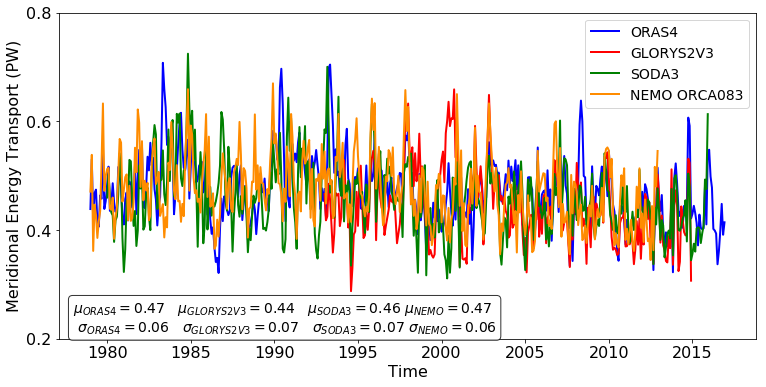

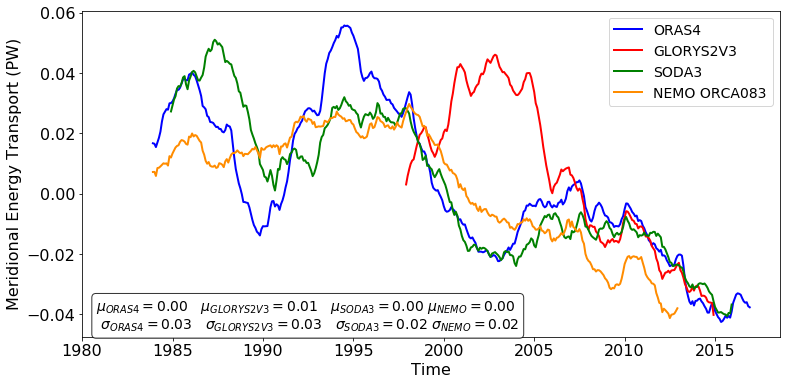

In [10]:
# index and namelist of years for time series and running mean time series
index_1993_begin = np.arange(1,265,1)
index_1993 = np.arange(169,433,1) # starting from index of year 1993
index_year_1993 = np.arange(1993,2015,1)

index_1979 = np.arange(1,457,1)
index_year_1979 = np.arange(1979,2017,1)

index_1980 = np.arange(13,445,1)
index_year_1980 = np.arange(1980,2016,1)

index_full = np.arange(1,457,1)
index_year_full = np.arange(1979,2017,1)

index_year = np.arange(1980,year_ORAS4[-1]+2,5)
# index_running_mean_1993 = np.arange(169,433-window+1,1)
# index_year_running_mean_1993 = np.arange(1993+window/12,2015,1)
#
# index_running_mean_1979 = np.arange(1,433-window+1,1)
# index_year_running_mean_1979 = np.arange(1979+window/12,2015,1)

text_content = '$\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ $\mu_{NEMO}=%.2f$ \n $\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$ $\sigma_{NEMO}=%.2f$' \
                % (OMET_ORAS4_mean, OMET_GLORYS2V3_mean, OMET_SODA3_mean, OMET_NEMO_mean, OMET_ORAS4_std, OMET_GLORYS2V3_std, OMET_SODA3_std, OMET_NEMO_std)

# plot the OMET series before removing seasonal cycle
fig1 = plt.figure()
plt.plot(index_1979,OMET_ORAS4_series[:,lat_interest['ORAS4'][4]],'b-',linewidth=2.0,label='ORAS4')
plt.plot(index_1993,OMET_GLORYS2V3_series[:,lat_interest['GLORYS2V3'][4]],'r-',linewidth=2.0,label='GLORYS2V3')
plt.plot(index_1980,OMET_SODA3_series[:,lat_interest['SODA3'][4]],'g-',linewidth=2.0,label='SODA3')
plt.plot(index_1979[:-48],OMET_NEMO_series[:,lat_interest['NEMO'][4]],color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
#plt.title('Oceanic Meridional Energy Transport at 60N (1979-2015)')
fig1.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(13,len(year_ORAS4)*12+12+1,60),index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(np.arange(0.2,1.0,0.2),fontsize=16)
plt.legend(frameon=True, loc=1, prop={'size': 14})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.02,0.12,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig1.savefig(output_path + os.sep + 'Comp_OMET_60N_time_series_1979_2015.png', dpi = 300)

# plot the running mean of OMET after removing seasonal cycle
text_content = '$\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ $\mu_{NEMO}=%.2f$ \n $\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$ $\sigma_{NEMO}=%.2f$' \
                % (OMET_ORAS4_white_running_mean_mean, OMET_GLORYS2V3_white_running_mean_mean, OMET_SODA3_white_running_mean_mean, OMET_NEMO_white_running_mean_mean, OMET_ORAS4_white_running_mean_std, OMET_GLORYS2V3_white_running_mean_std, OMET_SODA3_white_running_mean_std, OMET_NEMO_white_running_mean_std)

fig4 = plt.figure()
plt.plot(index_1979[window-1:],OMET_ORAS4_white_series_running_mean[:,lat_interest['ORAS4'][4]],'b-',linewidth=2.0,label='ORAS4')
plt.plot(index_1993[window-1:],OMET_GLORYS2V3_white_series_running_mean[:,lat_interest['GLORYS2V3'][4]],'r-',linewidth=2.0,label='GLORYS2V3')
plt.plot(index_1980[window-1:],OMET_SODA3_white_series_running_mean[:,lat_interest['SODA3'][4]],'g-',linewidth=2.0,label='SODA3')
plt.plot(index_1979[window-1:-48],OMET_NEMO_white_series_running_mean[:,lat_interest['NEMO'][4]],color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
#plt.title('Running Mean of OMET Anomalies at 60N with a window of 60 months (1979-2015)',window))
fig4.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(13,len(year_ORAS4)*12+12+1,60),index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=1, prop={'size': 14})
props = dict(boxstyle='round',facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.02,0.12,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig4.savefig(output_path + os.sep + 'Comp_OMET_anomaly_60N_running_mean_window_60m.png', dpi = 300)
